## Problem

References:

- https://gist.github.com/ArnoStrouwen/2d63dd943af63f864dd745d3e544a834

In [1]:
using DifferentialEquations, Distributions, Plots, Random

In [5]:
Random.seed!(51355113)

function dynamics!(du,u,p,t)
    du[1] = u[1] - p.θ[1]u[1]u[2] + p.input[1]
    du[2] = -3.0*u[2] + p.θ[2]u[1]*u[2] + p.input[2]
end

dynamics! (generic function with 1 method)

In [3]:
true_θ = [1.0, 1.0] #unknown parameters of the system
u0 = [1.0, 1.0] # lets start with deterministic initial conditions, later these can be made uncertain as well
tspan = (0.0, 10.0) # total duration of experiment
tmeasurements = 0.0:0.2:10.0 # time points where measurement is taken
tstops = 0.0:9.0 # time points where input can be switched

0.0:1.0:9.0

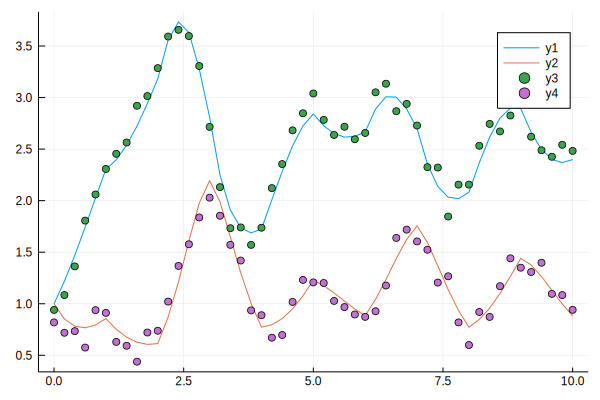

In [4]:
# parametrization of piecewise constant inputs that has to be optimized so that 
# θ can be recovered as precisely as possible
parametrized_input = [1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0;
                      1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0] 

struct Parameters{T,V}
    θ::T
    input::V
end
parameters = Parameters(true_θ,parametrized_input[:,1])

function affect!_generator(parametrized_input,tstops)
    function affect!(integrator)
        k = findfirst(isequal(integrator.t),tstops)
        integrator.p.input[:] .= parametrized_input[:,k]
    end
end
affect! = affect!_generator(parametrized_input,tstops)
cb = PresetTimeCallback(tstops,affect!;save_positions = (false,false))

true_prob = ODEProblem(dynamics!,u0,tspan,parameters) 
true_sol = solve(true_prob,Tsit5(), callback = cb,saveat=tmeasurements,dense=false)
true_state = hcat(true_sol.u...)
plot(tmeasurements,true_state');

measurement_noise = Uniform(-0.2,0.2)
measurements = true_state + rand(measurement_noise,size(true_state))
scatter!(tmeasurements,measurements')

#step 1 we need a method to get a set for θ based on the measurements
#step 2 some control inputs might result in smaller sets for θ, this is experimental design 

### Questions

> parametrization of piecewise constant inputs that has to be optimized so that θ can be recovered as precisely as possible?

- Not sure that I understand this sentence.
- What is the role of the parametrized inputs?

## Set-based method

In [7]:
using Revise, ReachabilityAnalysis
Random.seed!(51355113);

Let's begin by taking the input signal to be constantly zero.

Note: to define the PWC function defined above as `parametrized_input`, we would define a hybrid automaton with two modes, one in which `p.input[1] = p.input[2] = 0` and the other in which `p.input[1] = p.input[2] = 1`. The transition is time-triggered, so this should be relatively easy to handle. 

In [8]:
@taylorize function dynamics!(du,u,p,t)
    # original
    #du[1] = u[1] - p.θ[1]u[1]u[2] + p.input[1]
    #du[2] = -3.0*u[2] + p.θ[2]u[1]*u[2] + p.input[2]
    
    # modified
    du[1] = u[1] - u[3] * (u[1] * u[2]) # + u[5]
    du[2] = -3.0*u[2] + u[4] * (u[1] * u[2]) # + u[6]
    
    du[3] = zero(u[1]) # p.θ[1]
    du[4] = zero(u[1]) # p.θ[2]
#   du[5] = zero(u[1]) # p.input[1]
#   du[6] = zero(u[1]) # p.input[2]
end

In [25]:
# try a "small" parameter region
Θ = Interval(0.99, 1.01) × Interval(0.99, 1.01)
prob = @ivp(u' = dynamics!(u), dim: 4, u(0) ∈ Singleton(u0) × Θ);
sol = ReachabilityAnalysis.solve(prob, tspan, TMJets(max_steps=5_000));
solz = overapproximate(sol, Zonotope);

In [30]:
plot(solz, vars=(0, 1), lw=0.0, color=:blue, lab="x1", xlab="time")
plot!(solz, vars=(0, 2), lw=0.0, color=:red, lab="x2")

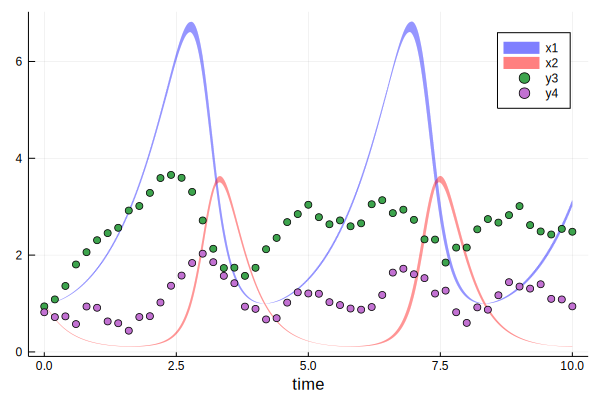

In [31]:
scatter!(tmeasurements,measurements')

The plots do not match, presumably because I have completely ignored the switching input.

In [32]:
# try a bigger parameter region
Θ = Interval(0.8, 1.2) × Interval(0.8, 1.2)
prob = @ivp(u' = dynamics!(u), dim: 4, u(0) ∈ Singleton(u0) × Θ);
sol = ReachabilityAnalysis.solve(prob, tspan, TMJets(max_steps=5_000));
solz = overapproximate(sol, Zonotope);

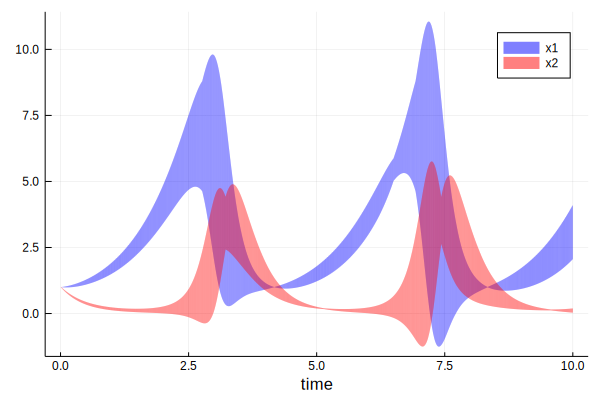

In [33]:
plot(solz, vars=(0, 1), lw=0.0, color=:blue, lab="x1", xlab="time")
plot!(solz, vars=(0, 2), lw=0.0, color=:red, lab="x2")